# Attendance AI
<br/>

# Import packages and load datasets
<br/>

In [1]:
import mmcv, cv2
from IPython import display
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
workers = 0 if os.name == 'nt' else 4

In [2]:
device = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu') # selecting cpu or gpu to use pytorch
print('Running on device: {}'.format(device))

Running on device: cpu


In [3]:
def collate_fn(x): # defining the list of samples to form a batch
    return x[0]
dataset = datasets.ImageFolder('knn_train') # data loading
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()} # distinguishing the key and value of the dataset
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers) # defining the data loader

# Training session
## MTCNN + InceptionResNet + KNN
<br/>

# 1. MTCNN

In [4]:
mtcnn = MTCNN(image_size=160, margin=0) # defining the face detecting module

# aligned is the set of cropped faces (face is cropped and simple face feature is extracted) 
# names is the list of class (name) of each picture
# photos is the set of pictures
aligned = [] 
names = [] 
photos = [] 
for x, y in loader:  
    photos.append(x) # storing the picture
    x_aligned, prob = mtcnn(x, return_prob=True) # mtcnn crop the face and extract the features of face
    if x_aligned is not None: # if the face is detected, then executes below lines
        print('Face detected with probability: {:8f}'.format(prob)) # the probability that face is included in detected box 
        aligned.append(x_aligned) # storing the cropped faces 
        names.append(dataset.idx_to_class[y]) # storing the class (name) of each picture

Face detected with probability: 0.999813
Face detected with probability: 0.999965
Face detected with probability: 0.999627
Face detected with probability: 0.999993
Face detected with probability: 0.999580
Face detected with probability: 0.999949
Face detected with probability: 0.999989
Face detected with probability: 1.000000
Face detected with probability: 0.999882
Face detected with probability: 0.999991
Face detected with probability: 0.999804
Face detected with probability: 0.999989
Face detected with probability: 0.999982
Face detected with probability: 0.999776
Face detected with probability: 1.000000
Face detected with probability: 0.999887
Face detected with probability: 0.999907
Face detected with probability: 0.999815
Face detected with probability: 0.999980
Face detected with probability: 0.999815
Face detected with probability: 0.999989
Face detected with probability: 0.999998
Face detected with probability: 0.999989
Face detected with probability: 0.999797
Face detected wi

In [5]:
# check length of aligned and names
print('length of aligned is %d and length of names is %d'%(len(aligned),len(names)))

length of aligned is 51 and length of names is 51


In [6]:
# Encoding the Labels (names)
from sklearn.preprocessing import LabelEncoder

names_enc=[]
out_encoder = LabelEncoder()  
out_encoder.fit(names) # LabelEncoder learns 'names' for fitting Encoder
names_enc = out_encoder.transform(names) # names_enc is encoded labels set

# 2. Inception ResNet
<br/>

In [7]:
# We use InceptionResNet to extract high level featrues from cropped face
# Loading InceptionResNetV1 model that was pretrained by vggface2 dataset
resnet = InceptionResnetV1(pretrained='vggface2').eval() 

# resenet.cuda() If you want to use cuda
resnet # putting the model into cuda
aligned_st = torch.stack(aligned).to(device) # calculating embedding (unsqueeze to add batch dimension)
img_embedding = resnet(aligned_st) # img_embedding is embedded features set

# 3. KNN classifier
<br/>

In [8]:
# We use KNN classifier to classify the face

from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
neighbors_settings = range(1,11) # setting the neighbors of KNN classifier
train_x = img_embedding.detach().numpy() # detaching the image into numpy array
train_y = names_enc # defining the image's label
for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) # setting KNN model
    clf.fit(train_x, train_y) # fitting the KNN model
    training_accuracy.append(clf.score(train_x, train_y)) # storing the training accuracy

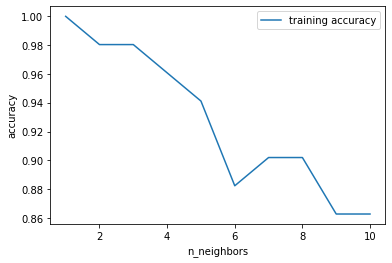

In [9]:
# Plot training accuracy curve (according to n_neighbors) 
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.ylabel("accuracy") 
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [10]:
# We define the the neighbors of KNN module that makes optimized accuracy
# But, considering the overfitting problem, we select n_neighbors = 3  
# It is because that we thought KNN with n_neighbors=1 has so high accuracy and high complexity
clf = KNeighborsClassifier(n_neighbors=3) 
clf.fit(train_x, train_y)
pred=clf.predict(train_x)

In [11]:
print(pred) # print prediction (label encoded)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 5 4 4 4 4 4 5 5 5 5 5 5 6 6 6 6 6 7
 7 7 7 7 8 8 8 8 8 9 9 9 9 9]


In [12]:
pred_name = out_encoder.inverse_transform(pred)
print(pred_name) # print prediction (label decoded)

['김지훈' '김지훈' '김지훈' '김지훈' '김지훈' '랩몬스터' '랩몬스터' '랩몬스터' '랩몬스터' '랩몬스터' '뷔' '뷔'
 '뷔' '뷔' '뷔' '석영' '석영' '석영' '석영' '승협' '슈가' '슈가' '슈가' '슈가' '슈가' '승협' '승협'
 '승협' '승협' '승협' '승협' '자민' '자민' '자민' '자민' '자민' '정국' '정국' '정국' '정국' '정국'
 '제이홉' '제이홉' '제이홉' '제이홉' '제이홉' '진' '진' '진' '진' '진']


In [13]:
train_name = out_encoder.inverse_transform(train_y)
print(train_name) # print name of training set (original class)

['김지훈' '김지훈' '김지훈' '김지훈' '김지훈' '랩몬스터' '랩몬스터' '랩몬스터' '랩몬스터' '랩몬스터' '뷔' '뷔'
 '뷔' '뷔' '뷔' '석영' '석영' '석영' '석영' '석영' '슈가' '슈가' '슈가' '슈가' '슈가' '승협' '승협'
 '승협' '승협' '승협' '승협' '자민' '자민' '자민' '자민' '자민' '정국' '정국' '정국' '정국' '정국'
 '제이홉' '제이홉' '제이홉' '제이홉' '제이홉' '진' '진' '진' '진' '진']


# Classify session
## classify the faces comming in to the class
<br/>

In [14]:
# import face recognition module
# It is maybe seen duplicated. But, the above one is just for the training and this one is for the prediction
mtcnn = MTCNN(image_size=160, margin=0, device=device)

In [15]:
video = mmcv.VideoReader('data/sh_ys1.mp4') # get videos using mmcv package  
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video] # store each of the frame from the video

In [18]:
fontsFolder = '/usr/share/fonts/truetype' # Directory of folder including fonts 
selectedFont = ImageFont.truetype(os.path.join(fontsFolder,'NanumGothic.ttf'),30) # Directory of fonts

faligned = [] # the list of cropped frames (face is cropped and simple face feature is extracted)
fphotos = [] # the set of original frames

for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='') # print the number of frames processed
    fphotos.append(frame) # storing the frame
    frame_aligned, prob = mtcnn(frame, return_prob=True) # mtcnn crop the frame and extract features of face 
    if frame_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        faligned.append(frame_aligned)

Tracking frame: 1Face detected with probability: 0.999639
Tracking frame: 2Face detected with probability: 0.999183
Tracking frame: 3Face detected with probability: 0.999125
Tracking frame: 4Face detected with probability: 0.999120
Tracking frame: 5Face detected with probability: 0.999777
Tracking frame: 6Face detected with probability: 0.999689
Tracking frame: 7Face detected with probability: 0.999689
Tracking frame: 8Face detected with probability: 0.999175
Tracking frame: 9Face detected with probability: 0.999175
Tracking frame: 10Face detected with probability: 0.999459
Tracking frame: 11Face detected with probability: 0.999898
Tracking frame: 12Face detected with probability: 0.999898
Tracking frame: 13Face detected with probability: 0.999274
Tracking frame: 14Face detected with probability: 0.999595
Tracking frame: 15Face detected with probability: 0.999595
Tracking frame: 16Face detected with probability: 0.999787
Tracking frame: 17Face detected with probability: 0.999787
Tracki

In [19]:
len(faligned) # length of cropped frames

72

In [20]:
# Load InceptionResNetV1 model that was pretrained by vggface2 dataset
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Calculate embedding (unsqueeze to add batch dimension)
# frame_embedding is embedded frame sets
faligned_st = torch.stack(faligned).to(device)
frame_embedding = resnet(faligned_st)

In [21]:
frame_embedding.shape

torch.Size([72, 512])

In [22]:
# predict name by knn (pretrained)
test_x=frame_embedding.detach().numpy()
pred=clf.predict(test_x)

In [23]:
pred_name = out_encoder.inverse_transform(pred)
print(pred_name)

['석영' '제이홉' '진' '김지훈' '뷔' '김지훈' '김지훈' '승협' '승협' '김지훈' '제이홉' '제이홉' '석영'
 '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영'
 '석영' '석영' '석영' '석영' '석영' '제이홉' '제이홉' '제이홉' '제이홉' '제이홉' '석영' '석영' '석영'
 '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '승협'
 '승협' '승협' '승협' '석영' '승협' '승협' '석영' '석영' '석영' '석영' '석영' '석영' '석영' '석영'
 '석영' '석영' '석영' '승협']


In [24]:
type(pred_name)

numpy.ndarray

In [25]:
# Draw the detected boungding box and the classified name

for i, frame in enumerate(frames):

    frames_tracked = [] # the set of tracked frames
    boxes, _ = mtcnn.detect(frame) # detect bounding box including face
    frame_draw = frame.copy() # make a copy of the frame
    draw = ImageDraw.Draw(frame_draw) # draw object on frame_draw
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6) # draw bounding box
        x_axis=boxes[0][0]-10 
        y_axis=boxes[0][1]-35
        draw.text((x_axis, y_axis),str(pred_name[i]),(100,255,255),font=selectedFont)# draw the classifed name 
        # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')


Done


In [ ]:
# Display finally processed video

d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [ ]:
# Save the processed video

dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4') # the type video saved
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim) # video names
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()